In [32]:
import numpy as np 
import nrrd

In [33]:
path_rank1="rank-1.nrrd"
path_rank2="rank-2.nrrd"
path_rank3="rank-3.nrrd"
path_avg="avg-1-20.nrrd"
path_wm="wmvolume.nrrd"
selected_index=2

In [34]:
# load all datasets

rank1,_ = nrrd.read(path_rank1)
rank2,_ = nrrd.read(path_rank2)
rank3,_ = nrrd.read(path_rank3)
average_model,_ = nrrd.read(path_avg)
wm, meta = nrrd.read(path_wm)

In [35]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))#
            0.0'
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.abs(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))*180/np.pi

In [36]:
ranks = np.concatenate((rank1,rank2,rank3), axis=1)
retval = np.zeros((*wm.shape,3))
for selected_index in range(1):
    for i,j,k in np.ndindex(ranks.shape[2:]):
        if wm[i,j,k] > 0.3:
            out = []
            for l in range(ranks.shape[1]):
                out.append(angle_between(average_model[1:, selected_index, i, j, k], ranks[1:, l, i,j,k]))
            retval[i,j,k,selected_index] = min(out)
        

In [88]:
ranks.shape

(4, 6, 145, 174, 145)

In [53]:
np.quantile(retval[wm>0.1,:].flatten(),0.99)

5.061015133337175

In [31]:
import matplotlib.pyplot as plt 


(array([1.35752e+05, 4.53920e+04, 3.39860e+04, 2.70200e+04, 2.25290e+04,
        1.85800e+04, 1.60360e+04, 1.42740e+04, 1.24920e+04, 1.09710e+04,
        9.81200e+03, 8.79700e+03, 7.96500e+03, 7.23500e+03, 6.65500e+03,
        6.02200e+03, 5.49400e+03, 5.10700e+03, 4.69600e+03, 4.37900e+03,
        4.03500e+03, 3.80200e+03, 3.46600e+03, 3.35500e+03, 3.08500e+03,
        2.80700e+03, 2.58800e+03, 2.43900e+03, 2.29000e+03, 2.19200e+03,
        2.06500e+03, 1.84200e+03, 1.79600e+03, 1.65200e+03, 1.51100e+03,
        1.35800e+03, 1.28200e+03, 1.18000e+03, 1.01900e+03, 1.00900e+03,
        9.40000e+02, 8.22000e+02, 8.02000e+02, 7.44000e+02, 6.71000e+02,
        5.80000e+02, 5.46000e+02, 4.88000e+02, 4.75000e+02, 4.21000e+02,
        3.80000e+02, 3.57000e+02, 2.98000e+02, 2.69000e+02, 2.60000e+02,
        2.15000e+02, 1.95000e+02, 1.81000e+02, 1.69000e+02, 1.34000e+02,
        1.14000e+02, 1.03000e+02, 1.06000e+02, 9.70000e+01, 8.00000e+01,
        5.30000e+01, 5.60000e+01, 4.60000e+01, 4.50

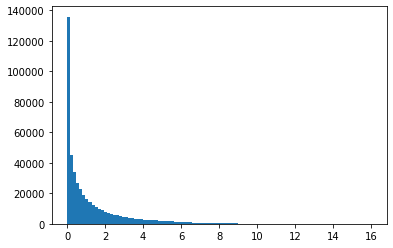

In [54]:

plt.hist(retval[wm>0.3,0].flatten(), bins=100)

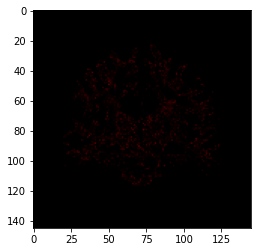

In [92]:
plt.imshow(np.rot90(retval[:,87,:])/30)


In [3]:
## Last experiment is now: low-rank-johannes/scripts/fa_tract_calc


from math import floor

def linear(point, vlinear, data):# nogil except *:

    for i in range(8):
        j = int(floor(i / 2) % 2)
        k = int(floor(i / 4) % 2)
        m = int(point[0] + i%2)
        n = int(point[1] + j)
        o = int(point[2] + k)
        vlinear[i] =  data[m,n,o]
   # print(vlinear)
    for i in range(4):
        vlinear[i] = (point[2] - floor(point[2])) * vlinear[4+i] + (1 + floor(point[2]) - point[2]) * vlinear[i]
    for i in range(2):
        vlinear[i] = (point[1] - floor(point[1]))* vlinear[2 + i ] +  (1 + point[1] - floor(point[1])) * vlinear[i]
    return  (point[0] - floor(point[0])) * vlinear[1] +  (1 + floor(point[0]) - point[0]) * vlinear[0]

from plyfile import PlyData
import nibabel as nib 
import numpy as np

In [4]:
path_ref='/mnt/uni/data/xderes/bootstrap/922854/tracts/CST_right.tck'
path_avg='/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-avg-1-20-bootstrap-Trilinear_0.ply'
path_rank='/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-rank-3-Trilinear_0.ply'
path_fa='/mnt/uni/data/xderes/bootstrap/922854/ankele/dti_FA.nii.gz'

In [5]:
with open(path_avg, 'rb') as f:
    plydata = PlyData.read(f)

    num_verts = plydata['vertices'].count
    num_fiber = plydata['fiber'].count
    vertices = np.ones(shape=[num_verts, 4], dtype=np.float64)
    endindex = np.zeros(shape=[num_fiber], dtype=np.float64)
    vertices[:, 0] = plydata['vertices'].data['x']
    vertices[:, 1] = plydata['vertices'].data['y']
    vertices[:, 2] = plydata['vertices'].data['z']
    endindex[:] = plydata['fiber'].data['endindex']
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-avg-1-20-bootstrap-Trilinear_0.ply'

In [6]:
fa_map = nib.load(path_fa)
## questionable: TODO doublecheck mapping. 
trafo = np.linalg.inv(fa_map.affine)
fa_map = fa_map.get_fdata()
ret_val = []
y=np.zeros((8,))
for i in range(num_verts): 
    
    index_coor = trafo @ vertices[i]
  #  print(index_coor)
    ret_val.append(linear(index_coor, y, fa_map))

print(np.mean(ret_val))



FileNotFoundError: No such file or no access: '/mnt/uni/data/xderes/bootstrap/922854/ankele/dti_FA.nii.gz'

In [7]:
from nibabel import streamlines as s

In [8]:
inval = s.load(path_ref)
vertices = np.ones((np.concatenate(inval.streamlines).shape[0], 4))
vertices[:, :3] = np.concatenate(inval.streamlines)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/uni/data/xderes/bootstrap/922854/tracts/CST_right.tck'

In [9]:
ret_val = []
y=np.zeros((8,))
for i in range(vertices.shape[0]): 
    
    index_coor = trafo @ vertices[i]
  #  print(index_coor)
    ret_val.append(linear(index_coor, y, fa_map))

print(np.mean(ret_val))

NameError: name 'vertices' is not defined

In [10]:
with open(path_rank, 'rb') as f:
    plydata = PlyData.read(f)

    num_verts = plydata['vertices'].count
    num_fiber = plydata['fiber'].count
    vertices = np.ones(shape=[num_verts, 4], dtype=np.float64)
    endindex = np.zeros(shape=[num_fiber], dtype=np.float64)
    vertices[:, 0] = plydata['vertices'].data['x']
    vertices[:, 1] = plydata['vertices'].data['y']
    vertices[:, 2] = plydata['vertices'].data['z']
    endindex[:] = plydata['fiber'].data['endindex']

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/uni/data/xderes/bootstrap/922854/output/922854-CST_right-rank-3-Trilinear_0.ply'

In [11]:
ret_val = []
y=np.zeros((8,))
for i in range(num_verts): 
    
    index_coor = trafo @ vertices[i]
  #  print(index_coor)
    ret_val.append(linear(index_coor, y, fa_map))

print(np.mean(ret_val))

NameError: name 'num_verts' is not defined

In [12]:
###matching code

In [1]:
from bonndit.tracking.interpolation import Trilinear
from bonndit.tracking.alignedDirection import ScalarOld
import nrrd
import numpy as np

In [2]:
directionGetter = ScalarOld(0,1) 
vectorfield, trafo = nrrd.read('./avg-1-20.nrrd')
trafo_data = np.zeros((4,4), dtype=np.float64)
trafo_data[3,3] = 1
trafo_data[:3,:3] = trafo['space directions'][2:]
tracking_parameters = {
		'trafo_data': trafo_data,
	}
my_point_index=np.array([74, 107, 72,1])



In [4]:
trilinear = Trilinear(np.array(vectorfield, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)

In [5]:
wm, _ = nrrd.read('wmvolume.nrrd')

In [6]:
wm = np.array(np.where(wm>0.3))

In [30]:
def orth(k):
    x = np.random.randn(3)  # take a random vector
    x -= x.dot(k) * k       # make it orthogonal to k
    x /= np.linalg.norm(x)
    y = np.cross(k, x)
    return x,y

my_angle = 0.087

retval = []
applyed_ang = []
from tqdm import tqdm
retval_matching = []
#for l in range(1):
my_ang=[]
my_matching = []
for j in tqdm(range(100)):
    trilinear = Trilinear(np.array(vectorfield, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)
    selected=np.random.choice(range(wm.shape[1]))
    # select worst case
    mp = wm[:,selected]
    my_point_index=wm[:,selected] + np.array([0.5,0.5,0.5])
    my_point  =trafo_data@np.array([*my_point_index,1])
    trilinear.set_best_dirp(np.zeros((3,3)))
    #print(trilinear.best_dirp())
    trilinear.interpolate(my_point[:3], np.array([1,1,0,0], dtype=np.float64), 1)
   # print(trilinear.best_dirp())
   # for i in range(10):
    vectorfield2 = np.copy(vectorfield)
    for x in range(2):
        for y in range(2):
            for z in range(2):
                for u in range(3):
                    if np.linalg.norm(vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z]) != 0:
                        normed_vector = vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z]/np.linalg.norm(vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z])
                        orth1, orth2 = orth(normed_vector)
                        # results in 10 degrees? 
                        r = np.random.uniform(0,1)
                        sigma = np.random.uniform(0,np.pi*2)
                        X = my_angle*r * np.cos(sigma) 
                        Y = my_angle*r * np.sin(sigma)
                        vector = normed_vector +  X*orth1  + Y*orth2
                        applyed_ang.append(angle_between(vector, normed_vector))
                        vectorfield2[1:, u,mp[0] + x,mp[1] + y,mp[2] + z] = vector/np.linalg.norm(vector) 

    trilinear_noised = Trilinear(np.array(vectorfield2, dtype=np.float64) , np.array(vectorfield.shape[2:], dtype=np.int32), directionGetter, **tracking_parameters)
 #   print(0, trilinear.best_dirp())
#    trilinear_noised.set_best_dirp(trilinear.best_dirp())
    trilinear_noised.interpolate(my_point[:3], np.array([1,1,0,0], dtype=np.float64), 1)
    print([angle_between(trilinear_noised.best_dirp()[0], trilinear.best_dirp()[i]) for i in range(3)])
    
    my_ang.append(min(angle_between(trilinear.best_dirp()[0], trilinear_noised.best_dirp()[0]),angle_between(trilinear.best_dirp()[0], trilinear_noised.best_dirp()[1]),angle_between(trilinear.best_dirp()[0], trilinear_noised.best_dirp()[2])))
    my_matching.append((trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),0],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),0],trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),4],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),4],trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),8],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),8],trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),12],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),12],trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),16],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),16],trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),20],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),20],trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),24],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),24],trilinear.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),28],trilinear_noised.cachep()[int(my_point_index[0]),int(my_point_index[1]),int(my_point_index[2]),28]))


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

[1.588724331777423, 75.12787357477248, 31.586866121786848]


  1%|▊                                                                                 | 1/100 [00:01<01:45,  1.07s/it]

[1.266292381641095, 58.43945573551105, 6.518572059690506]


  2%|█▋                                                                                | 2/100 [00:02<01:48,  1.11s/it]

[0.989143861170699, 39.48223934093793, 88.17923455068046]


  3%|██▍                                                                               | 3/100 [00:03<01:45,  1.09s/it]

[5.512640983045357, 65.5593195663822, 77.86051183882128]


  4%|███▎                                                                              | 4/100 [00:04<01:43,  1.08s/it]

[0.737548940345471, 89.3430312258909, 10.859337379609466]


  5%|████                                                                              | 5/100 [00:05<01:42,  1.08s/it]

[0.960122711547287, 49.67010130835976, 41.37726102756782]


  6%|████▉                                                                             | 6/100 [00:06<01:40,  1.07s/it]

[0.7710182587810755, 56.37197445307045, 42.92510583884799]


  7%|█████▋                                                                            | 7/100 [00:07<01:39,  1.07s/it]

[0.4679593836666343, 52.23314615595546, 38.24263030051972]


  8%|██████▌                                                                           | 8/100 [00:08<01:37,  1.06s/it]

[1.0594560070905576, 68.07111872451763, 54.469867502349935]


  9%|███████▍                                                                          | 9/100 [00:09<01:37,  1.07s/it]

[2.013471144728812, 74.83318634147271, 40.220849029498225]


 10%|████████                                                                         | 10/100 [00:10<01:36,  1.07s/it]

[1.1980581138029298, 39.168202792982015, 43.64816571914495]


 11%|████████▉                                                                        | 11/100 [00:11<01:36,  1.08s/it]

[0.4369553790834705, 57.192228941485915, 69.11962054804764]


 12%|█████████▋                                                                       | 12/100 [00:12<01:36,  1.09s/it]

[1.350261072843242, 77.70882636465325, 83.55961373945505]


 13%|██████████▌                                                                      | 13/100 [00:14<01:34,  1.09s/it]

[0.5292498697755437, 47.11187372830246, 84.92684976574125]


 14%|███████████▎                                                                     | 14/100 [00:15<01:34,  1.10s/it]

[3.8412236217864004, 68.6244546857537, 47.19562656235519]


 15%|████████████▏                                                                    | 15/100 [00:16<01:34,  1.11s/it]

[0.48196481894961213, 10.655584089938156, 7.239496854579608]


 16%|████████████▉                                                                    | 16/100 [00:17<01:32,  1.10s/it]

[5.922372845498873, 60.36696162944842, 36.22637241531948]


 17%|█████████████▊                                                                   | 17/100 [00:18<01:31,  1.10s/it]

[0.44750015444490215, 37.09314875845528, 21.754479323123984]


 18%|██████████████▌                                                                  | 18/100 [00:19<01:30,  1.10s/it]

[1.0366163300621902, 54.55541596939456, 14.682976532946206]


 19%|███████████████▍                                                                 | 19/100 [00:20<01:29,  1.10s/it]

[0.8882227939404843, 28.86176003863929, 19.910838548734606]


 20%|████████████████▏                                                                | 20/100 [00:21<01:28,  1.10s/it]

[4.390928151402676, 39.69915043634918, 38.04130186752209]


 21%|█████████████████                                                                | 21/100 [00:22<01:27,  1.10s/it]

[0.8359867290767805, 58.84976794154183, 72.92496492582947]


 22%|█████████████████▊                                                               | 22/100 [00:24<01:25,  1.10s/it]

[6.929702802352404, 37.02808786161373, 51.07224211909916]


 23%|██████████████████▋                                                              | 23/100 [00:25<01:25,  1.11s/it]

[1.3957701399773659, 53.250979257129124, 34.19690752678667]


 24%|███████████████████▍                                                             | 24/100 [00:26<01:24,  1.11s/it]

[1.272457839303482, 52.376094414601695, 58.55068013451362]


 25%|████████████████████▎                                                            | 25/100 [00:27<01:22,  1.10s/it]

[1.7205011755761066, 66.17550519211144, 41.242629623187185]


 26%|█████████████████████                                                            | 26/100 [00:28<01:21,  1.10s/it]

[0.2951092059157149, 56.272398970687846, 45.353753678432774]


 27%|█████████████████████▊                                                           | 27/100 [00:29<01:20,  1.11s/it]

[5.337007310208295, 29.778349008494935, 79.6380529823573]


 28%|██████████████████████▋                                                          | 28/100 [00:30<01:20,  1.12s/it]

[5.611903529814115, 59.39014307993122, 51.58220746371333]


 29%|███████████████████████▍                                                         | 29/100 [00:31<01:19,  1.12s/it]

[0.6629174800630243, 51.66308212685222, 51.41754455563717]


 30%|████████████████████████▎                                                        | 30/100 [00:32<01:18,  1.12s/it]

[0.6063334428462439, 69.42468372573745, 56.595820613707986]


 31%|█████████████████████████                                                        | 31/100 [00:34<01:19,  1.15s/it]

[1.7188528136632117, 20.0932438500931, 10.615895681413708]


 32%|█████████████████████████▉                                                       | 32/100 [00:35<01:16,  1.13s/it]

[7.206970326018558, 77.5754505046546, 34.90632994629439]


 33%|██████████████████████████▋                                                      | 33/100 [00:36<01:14,  1.12s/it]

[0.6069746291057562, 30.08459278354732, 8.91735154272337]


 34%|███████████████████████████▌                                                     | 34/100 [00:37<01:12,  1.10s/it]

[0.9901476327145605, 36.56856002882622, 40.571477445704375]


 35%|████████████████████████████▎                                                    | 35/100 [00:38<01:12,  1.12s/it]

[17.359711907605703, 73.03266764822872, 40.00942756771132]


 36%|█████████████████████████████▏                                                   | 36/100 [00:39<01:10,  1.11s/it]

[1.0377107238577779, 16.01708262298272, 39.43463835160128]


 37%|█████████████████████████████▉                                                   | 37/100 [00:40<01:09,  1.10s/it]

[0.4802743522880003, 84.35812445196959, 57.970636891873156]


 38%|██████████████████████████████▊                                                  | 38/100 [00:41<01:07,  1.10s/it]

[3.240309555311812, 87.9804713301787, 58.16222945875965]


 39%|███████████████████████████████▌                                                 | 39/100 [00:42<01:06,  1.10s/it]

[1.2928048028584869, 66.03913425090474, 27.324977698774635]


 40%|████████████████████████████████▍                                                | 40/100 [00:43<01:05,  1.09s/it]

[0.4510056881850213, 42.11050144832354, 57.00903873120228]


 41%|█████████████████████████████████▏                                               | 41/100 [00:45<01:04,  1.09s/it]

[0.6782185522014961, 51.08467958353652, 37.509580779355275]


 42%|██████████████████████████████████                                               | 42/100 [00:46<01:03,  1.09s/it]

[0.31386428360446716, 70.18718382072663, 86.249937527271]


 43%|██████████████████████████████████▊                                              | 43/100 [00:47<01:01,  1.08s/it]

[0.8999095366838489, 65.48241054894561, 22.075836481569]


 44%|███████████████████████████████████▋                                             | 44/100 [00:48<01:00,  1.09s/it]

[3.83010623144103, 49.497167701809374, 68.48224632553634]


 45%|████████████████████████████████████▍                                            | 45/100 [00:49<01:00,  1.09s/it]

[1.167150082921645, 81.75925594680601, 86.5096873602574]


 46%|█████████████████████████████████████▎                                           | 46/100 [00:50<00:58,  1.09s/it]

[0.04798350289702168, 57.801680608560126, 29.369287817350497]


 47%|██████████████████████████████████████                                           | 47/100 [00:51<00:57,  1.08s/it]

[7.335272739212152, 63.57842953844786, 49.235150812558096]


 48%|██████████████████████████████████████▉                                          | 48/100 [00:52<00:56,  1.08s/it]

[0.7311117271636312, 36.71556987376283, 6.189174265415856]


 49%|███████████████████████████████████████▋                                         | 49/100 [00:53<00:55,  1.08s/it]

[8.199524658398074, 74.443147673839, 25.374717373961985]


 50%|████████████████████████████████████████▌                                        | 50/100 [00:54<00:53,  1.08s/it]

[1.206630158600394, 64.09982712982193, 35.167477625469516]


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:55<00:52,  1.08s/it]

[0.27149734968105654, 63.97684581019256, 27.8520531984212]


 52%|██████████████████████████████████████████                                       | 52/100 [00:56<00:51,  1.07s/it]

[1.4406531870465127, 52.84535680066549, 44.72354965790117]


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:58<00:50,  1.07s/it]

[0.8150154529322089, 59.698165674240556, 86.76662018608127]


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:59<00:49,  1.08s/it]

[1.2390904641800862, 89.38674821654293, 75.65263327169465]


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:00<00:48,  1.08s/it]

[0.27464830470138457, 54.70187850708918, 41.629108394249045]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:01<00:47,  1.08s/it]

[0.2528725167273968, 36.78301065642668, 51.06483692561582]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:02<00:46,  1.08s/it]

[6.81602069453198, 73.54435653968979, 30.32255333812614]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:03<00:45,  1.08s/it]

[0.689887647091276, 60.268455070835245, 37.8691384031483]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:04<00:44,  1.08s/it]

[1.2590503512572262, 75.91589160700414, 47.02933147421905]


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:05<00:43,  1.08s/it]

[0.4912393068605791, 43.80584503010967, 6.5061920026254505]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:06<00:41,  1.07s/it]

[1.506556453427333, 70.8861494283715, 54.02538662124831]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:07<00:40,  1.07s/it]

[1.4326692877709681, 15.429468487620264, 2.6541612650323216]


 63%|███████████████████████████████████████████████████                              | 63/100 [01:08<00:39,  1.07s/it]

[0.9167742139805637, 53.48845201568251, 60.54610752536013]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:09<00:38,  1.07s/it]

[16.884569020836693, 73.71885376148762, 51.882090483043676]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:10<00:37,  1.07s/it]

[0.29872747162089847, 60.769201043310375, 49.138081685351004]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:11<00:36,  1.07s/it]

[0.34502775443490413, 63.16717305278037, 35.09756094219016]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:13<00:35,  1.07s/it]

[0.9450308996362521, 68.74902044383781, 64.24402965372809]


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:14<00:34,  1.07s/it]

[1.1075182394579297, 61.32867748161381, 52.20590056189599]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:15<00:33,  1.07s/it]

[0.585671678791, 69.05924075757405, 50.431380677414204]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:16<00:31,  1.07s/it]

[6.866076359023727, 40.11913081890795, 55.04496545057039]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:17<00:30,  1.06s/it]

[0.6101569719966408, 28.545755851453844, 21.830193842017092]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:18<00:29,  1.07s/it]

[1.091489472354984, 21.089031507356573, 34.636162899348]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:19<00:28,  1.07s/it]

[1.320053202218123, 23.557436057205642, 57.5589070406619]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:20<00:27,  1.06s/it]

[1.5064515391637847, 41.10676723690697, 16.96168763979073]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:21<00:26,  1.07s/it]

[1.1880508181149692, 60.66494593354622, 74.55646882809097]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:22<00:25,  1.06s/it]

[2.154227494704956, 40.05709836986588, 35.01497239542468]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:23<00:24,  1.06s/it]

[0.9077930529822559, 27.795205329032694, 14.136092920436273]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:24<00:23,  1.07s/it]

[2.0717839388686135, 54.023721173676186, 64.51000462479975]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:25<00:22,  1.06s/it]

[0.57730694587791, 69.14081626864528, 43.299632652426936]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:26<00:21,  1.06s/it]

[1.2453584857757969, 28.667497041769384, 58.843949655324856]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:27<00:20,  1.07s/it]

[0.5176701349245472, 88.58120320620385, 89.3039656045839]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:28<00:19,  1.06s/it]

[0.7943616619550606, 82.65485024063979, 52.76016281706777]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:30<00:18,  1.06s/it]

[0.8013858156811432, 65.24857049872082, 38.796038478313974]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:31<00:17,  1.07s/it]

[0.3519314717161834, 71.5059120351507, 33.604050272743976]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:32<00:15,  1.07s/it]

[6.1915216681665095, 37.802687604396816, 22.452033583739468]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:33<00:14,  1.07s/it]

[1.4288950516329797, 70.31847951761857, 50.789756040616076]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:34<00:13,  1.07s/it]

[0.930400722008074, 17.039791240045048, 26.673056264801236]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:35<00:12,  1.07s/it]

[6.370456321685414, 49.72016465393001, 42.83644454640802]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:36<00:11,  1.06s/it]

[4.435381938937695, 36.509636496518524, 63.16599206845741]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:37<00:10,  1.07s/it]

[1.1633725945111486, 27.6984176884374, 29.292562734573014]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:38<00:09,  1.06s/it]

[1.0200060410100111, 57.49344744295944, 40.8394327964638]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:39<00:08,  1.06s/it]

[1.291146623085573, 34.531736689828136, 55.12699823429371]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:40<00:07,  1.07s/it]

[0.5617379613276273, 32.19726108291115, 27.483859563380673]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:41<00:06,  1.07s/it]

[1.4353022593834133, 6.493740330019105, 17.426396469287106]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:42<00:05,  1.07s/it]

[0.4000206941313029, 32.408261445086815, 27.806410458537886]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:43<00:04,  1.07s/it]

[0.43827607732813867, 54.49300541918127, 61.59017231410328]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:44<00:03,  1.07s/it]

[1.8908855393949566, 57.25590774800694, 83.05296739959573]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:46<00:02,  1.07s/it]

[1.6203877527633364, 45.941266932825464, 47.98187734083646]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:47<00:01,  1.08s/it]

[0.8827192582295394, 58.29748271434014, 52.332153807318335]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


In [22]:
x = np.array(my_matching)[:,::2]-np.array(my_matching)[:,1::2]
x[x==-1] = 0
x[x==1] = 0

np.count_nonzero(np.linalg.norm(x, axis=-1))

49

In [23]:
x

array([[ 0,  0,  0,  0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  2,  0,  4],
       [ 0,  0,  0,  0,  0,  2,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0, -3,  0,  0],
       [ 0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4],
       [ 3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, -3,  0, -3,  0, -3,  0,  4],
       [ 0,  0, -3,  0,  0,  0,  0,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 

In [75]:
[np.median(retval[i]) for i in range(10)]

IndexError: list index out of range

In [67]:
[np.var(retval[i]) for i in range(10)]

[0.13752465096892316,
 0.5922308218649476,
 1.2652298927643935,
 2.228179972630778,
 3.4262654314459895,
 5.014081324493932,
 6.740649451684565,
 8.985462334456058,
 11.110232870703111,
 15.460414620052987]

In [70]:
[np.linalg.norm(x, 0) for x in retval_matching]

[1.0, 4.0, 3.0, 6.0, 4.0, 1.0, 6.0, 4.0, 8.0, 5.0]

In [63]:
retval = []
my_vec = np.array([1,0,0])
for l in range(1,11):
    my_angle = []
    for j in range(1000):
        my_angle.append(angle_between(my_vec, my_vec + np.random.normal(0,l/100,3)))
    retval.append(my_angle)

In [64]:
[np.max(retval[i]) for i in range(10)]

[2.027799091459587,
 4.6127111808223,
 6.4179490744046195,
 7.675806696395367,
 10.488814896357622,
 12.24400512971291,
 14.88713382622476,
 15.603319452685904,
 19.1944943444239,
 22.25658700253761]

In [45]:
[np.var(retval[i]) for i in range(10)]

[0.13937145463878653,
 0.5523210041327891,
 1.295974021041257,
 2.2142552337016785,
 3.2523459281400586,
 5.1809341070102635,
 6.642792335977857,
 9.50775649504,
 11.740659674543156,
 14.901856092584064]